# 算法建模

## 分类器脉络

分类器的大致脉络如下：<br>
<img src=figtabs/ch5/clf.png align=center width=65% height=65% />

## 加载相关模块

基本的几个包：

In [1]:
import itertools
import pickle
from itertools import cycle
from math import ceil, floor

数据挖掘常用的几个模块：

In [2]:
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import graphviz

近邻法

In [3]:
from sklearn.neighbors import KNeighborsClassifier

决策树

In [4]:
from sklearn.tree import DecisionTreeClassifier,plot_tree,export_graphviz

In [5]:
from dtreeviz.trees import *

随机森林

In [6]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

朴素贝叶斯

In [7]:
from sklearn.naive_bayes import GaussianNB

逻辑斯蒂回归

In [8]:
from sklearn.linear_model import LogisticRegression

人工神经网络

In [9]:
from sklearn.neural_network import MLPClassifier

支持向量机

In [10]:
from sklearn.svm import SVC

模型评估与参数调优

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

特征降维

In [12]:
from sklearn.decomposition import PCA

决策边界绘制

In [13]:
from mlxtend.plotting import plot_decision_regions

更好的一些可视化的方法

In [14]:
import scikitplot as skplt

For more details about scikitplot, visit https://scikit-plot.readthedocs.io/en/stable/Quickstart.html

## 一些简单设置

In [15]:
# 在Jupyter中，除非加上print，每个cell只会显示最后一个输出结果
# 通过加上如下代码，使之打印所有的交互式输出，而不仅仅是最后一个
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [16]:
plt.style.use("classic")
plt.rcParams["font.sans-serif"] = ["FangSong"]  # 制定默认字体
plt.rcParams["axes.unicode_minus"] = False  # 解决负号显示为方块的问题
%matplotlib inline

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
rng = np.random.RandomState(2012)

## 数据集划分

In [19]:
with open("pickle/ch5_data.pkl", "rb") as f:
    objects_awaken = pickle.load(f)
X_numeric = objects_awaken["X_numeric"]
y_numeric = objects_awaken["y_numeric"]

In [20]:
X_numeric

,yw,sx,wy,zz,ls,dl,wl,hx,sw,xb_nan,xb_nv
0,94,82,96,97,97,98,95,94,88,0,1
1,87,94,89,95,94,94,90,90,89,1,0
2,92,79,86,98,95,96,89,94,87,1,0
3,91,84,96,93,97,94,82,90,83,0,1
4,85,92,82,93,87,88,95,94,93,1,0
...,...,...,...,...,...,...,...,...,...,...,...
770,79,78,70,83,86,86,76,78,70,1,0
771,87,63,55,93,100,94,43,88,82,1,0
772,85,59,89,80,85,82,61,64,75,1,0
773,81,62,76,89,76,91,49,68,74,1,0


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_numeric, y_numeric, test_size=0.3, random_state=rng
)

数据集划分为训练和测试数据集，要尽量保留有价值的信息，这些信息将有利于训练机器学习算法。因此，我们一般不会为测试数据集分配太多的数据。不过，测试集越小，对泛化误差的估计将会越不准确。在对数据集进行划分时，需要对此进行权衡。在实际应用中，基于原始数据的大小，常用的划分比例是60:40、70:30，或者80:20。对于非常庞大的数据集，将训练集和测试集的比例按照90:10或者99:1进行划分也是常见且可以接受的。

In [22]:
X_train.shape

(541, 11)

In [23]:
import numpy as np


def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

## 特征标准化

特征缩放（feature scaling）是数据预处理过程中至关重要的一步，但却极易被人们忽略。决策树和随机森林是机器学习算法中为数不多的不需要进行特征缩放的算法。然而，对大多数机器学习和优化算法而言，将特征的值缩放到相同的区间可以使其性能更佳。   

$x_i^{std} = \frac{{{x_i} - \min \left( x \right)}}{{\max \left( x \right) - \min \left( x \right)}}$

用Python语言来描述的话，与数学语言完全一样：

$X' = \frac{{X - np.min\left( X \right)}}{{np.max\left( X \right) - np.min\left( X \right)}}$

我们不主张重复造轮子，在工业级/商业级实践中，直接用sklearn就好：

In [24]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

也可以采用如下标准化的方法：  

$x_i^{std} = \frac{{{x_i} - \mu }}{\sigma }$

当然，在sklearn中也早有标准的实现：

In [25]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

StandardScaler()

当然，自己写代码实现一下，其实也不复杂：

In [26]:
X_train_std = X_train.copy()
X_train_std.iloc[:, 0] = (
    X_train.iloc[:, 0] - X_train.iloc[:, 0].mean()
) / X_train.iloc[:, 0].std()

在上面的代码中，从preprocessing模块中加载了StandardScaler类，并实例化了一个StandardScaler对象，用变量sc作为对它的引用。使用StandardScaler中的fit方法，可以计算训练数据中每个特征的$\mu $（样本均值）和$\sigma$（标准差）。通过调用transform方法，可以使用前面计算得到的$\mu $和$\sigma$来对训练数据做标准化处理。

## 模型评估

In [27]:
from sklearn.metrics import accuracy_score


def print_performance(real, pred):
    print("误分样本数（Misclassified samples）: {}".format((real != pred).sum()))
    print("准确率(accuracy): {:.2f}%".format(accuracy_score(real, pred) * 100))

## 近邻法

从过程来讲，学习可以分为两种：<br>
* 急切学习法Eager Learner：在接收待分类的新元组之前就构造泛化模型。决策树归纳、贝叶斯分类、基于规则的分类等都属于急切学习法
* 惰性学习法Lazy Learner：当给定一个训练元组时，简单地存储它（或稍加处理），并且一直等待，直到给定一个检验元组。仅当看到检验元组时，才进行泛化，以便根据与存储元组的相似性对该元组进行分类。惰性学习在提供训练元组时只做少量工作，在分类或数值预测时做更多工作。<br>

近邻法属于惰性学习发法，其原理非常简单直观：拿到一个测试样本时，在数据空间里环顾四周，看看身边的$k$小伙伴头上大多贴的什么标签，然后把自己也贴上相同的标签。

输入：最近邻数目$k$，训练集$S$，测试集$T$  
输出：对测试集$T$中所有测试样本预测其类标号值  
1. for 每个测试样本$z = \left( {{X^*},{y^*}} \right) \in T$   
2. &emsp;&emsp;计算$𝑧$和每个训练样本$\left( {X,y} \right) \in S$之间的距离$d\left( {X,{X^*}} \right)$  
3. &emsp;&emsp;选择离$𝑧$最近的$k$最近邻集合${S_z} \subseteq S$
4. &emsp;&emsp;多数表决${y^*} = \mathop {\arg \max }\limits_v \sum\nolimits_{\left( {{X_i},{y_i}} \right) \in {D_Z}} {I\left( {v = {y_i}} \right)}$     
5. end for

In [28]:
clf_knn = KNeighborsClassifier(n_neighbors=5, weights="uniform")
clf_knn.fit(X_train, y_train)
y_test_pred = clf_knn.predict(X_test)
print_performance(y_test, y_test_pred)

KNeighborsClassifier()

误分样本数（Misclassified samples）: 66
准确率(accuracy): 71.55%


In [29]:
clf_knn2 = KNeighborsClassifier(n_neighbors=7, p=2, metric="minkowski")
clf_knn2.fit(X_train, y_train)
y_test_pred_knn2 = clf_knn2.predict(X_test)
print_performance(y_test, y_test_pred_knn2)

KNeighborsClassifier(n_neighbors=7)

误分样本数（Misclassified samples）: 60
准确率(accuracy): 74.14%


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

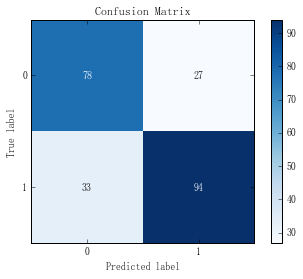

In [30]:
skplt.metrics.plot_confusion_matrix(y_test, y_test_pred_knn2, normalize=False)
plt.show()

In [31]:
y_test_pred_prob_knn2 = clf_knn2.predict_proba(X_test)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

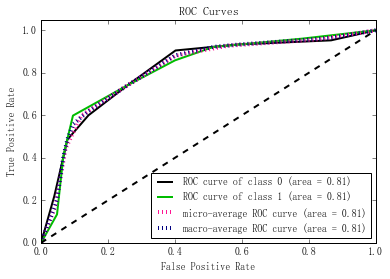

In [32]:
skplt.metrics.plot_roc(y_test, y_test_pred_prob_knn2)

## 决策树

决策树是一个倒着生长的树：<br>
<img src=figtabs/ch5/cart.png align=left width = 50%/>

决策树的生长：递归划分、不断生长；局部最优、步步为赢<br>
如果数据无需再分（如当前数据记录类标签同为一类）、或是无法再分（如所有记录的属性值相同、或是数据记录数太少），则建立叶子结点，并按照少数服从多数（有生于无）的原则，给叶子结点打上标签；否则，寻找一个属性，根据该属性的不同取值情况，把数据分成纯度较大的两个（或几个）子集。对于这些子集，递归执行以上操作，开枝散叶。<br>
<img src=figtabs/ch5/cart_a.png align=left width = 50%/>

决策树的原理大致都差不多，不同点在于不同算法不纯度的度量：<br>
<img src=figtabs/ch5/cart_impurity.png align=left width = 50%/>

🌈🌈🌈🌈  **Time to Play**  ✨✨✨✨

分裂准则执行过程：先找到某个最佳属性、然后在这个属性特征上找一个最佳分裂点？比如在所有9门科目中，选择hx，然后选择在hx >= 54, hx >= 61, ...中选择hx > 95?

In [33]:
clf_dt = DecisionTreeClassifier(criterion="gini", max_depth=4, random_state=2012)
clf_dt.fit(X_train, y_train)
y_test_pred_dt = clf_dt.predict(X_test)
print_performance(y_test, y_test_pred_dt)

DecisionTreeClassifier(max_depth=4, random_state=2012)

误分样本数（Misclassified samples）: 68
准确率(accuracy): 70.69%


<Figure size 1440x1080 with 0 Axes>

[Text(558.0, 753.3, 'hx <= 95.0\ngini = 0.5\nsamples = 100.0%\nvalue = [0.506, 0.494]\nclass = like'),
 Text(279.0, 585.9, 'xb_nan <= 0.5\ngini = 0.444\nsamples = 57.1%\nvalue = [0.333, 0.667]\nclass = wenke'),
 Text(139.5, 418.5, 'sw <= 84.5\ngini = 0.3\nsamples = 31.2%\nvalue = [0.183, 0.817]\nclass = wenke'),
 Text(69.75, 251.10000000000002, 'ls <= 64.5\ngini = 0.147\nsamples = 18.5%\nvalue = [0.08, 0.92]\nclass = wenke'),
 Text(34.875, 83.69999999999993, 'gini = 0.0\nsamples = 0.2%\nvalue = [1.0, 0.0]\nclass = like'),
 Text(104.625, 83.69999999999993, 'gini = 0.131\nsamples = 18.3%\nvalue = [0.071, 0.929]\nclass = wenke'),
 Text(209.25, 251.10000000000002, 'ls <= 91.5\ngini = 0.444\nsamples = 12.8%\nvalue = [0.333, 0.667]\nclass = wenke'),
 Text(174.375, 83.69999999999993, 'gini = 0.499\nsamples = 7.0%\nvalue = [0.526, 0.474]\nclass = like'),
 Text(244.125, 83.69999999999993, 'gini = 0.175\nsamples = 5.7%\nvalue = [0.097, 0.903]\nclass = wenke'),
 Text(418.5, 418.5, 'zz <= 91.5\ngi

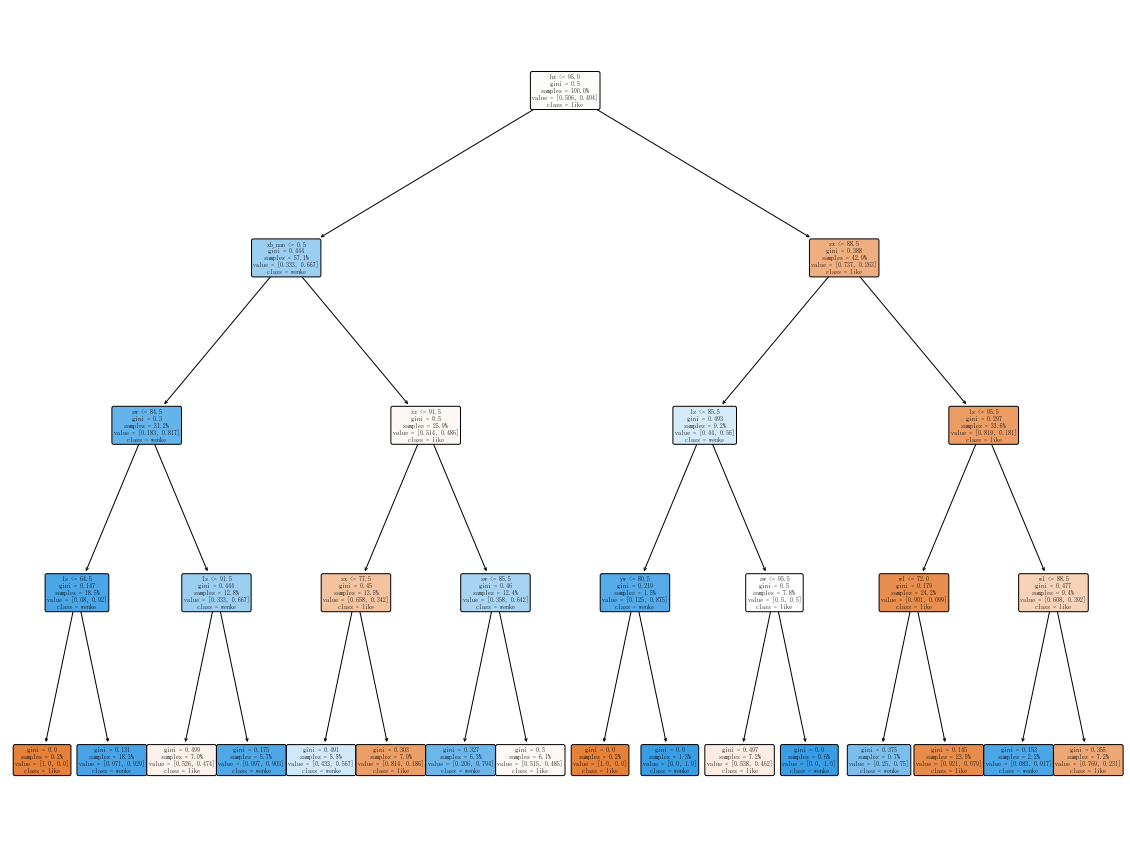

In [34]:
plt.figure(figsize=(20, 15))
plot_tree(
    clf_dt,
    feature_names=X_train.columns.values,
    class_names=["like", "wenke"],
    rounded=True,
    proportion=True,
    filled=True,
    ax=plt.gca(),
)

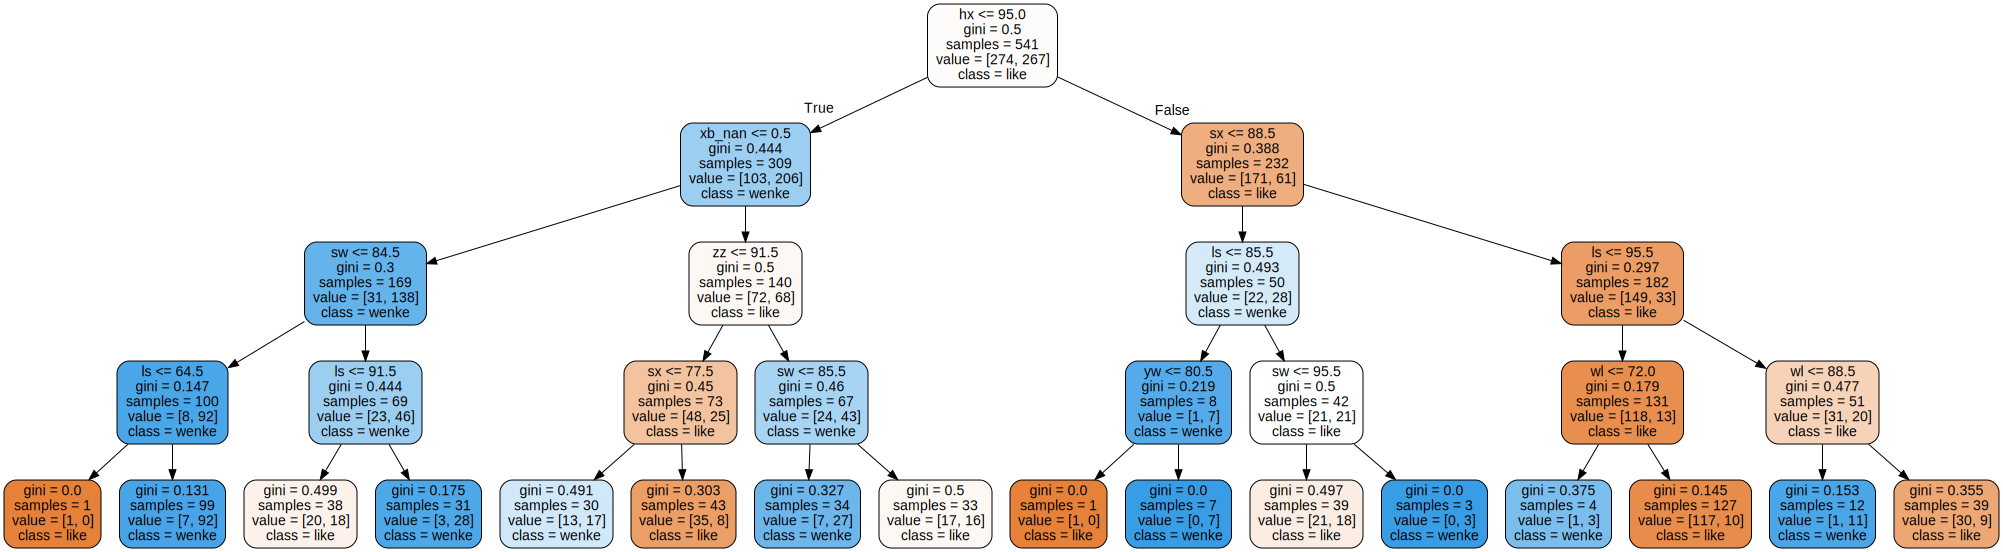

In [35]:
dot_data = export_graphviz(
    clf_dt,
    feature_names=X_train.columns.values,
    class_names=["like", "wenke"],
    rounded=True,
    filled=True,
)
graph = graphviz.Source(dot_data)
graph

上述代码当然有点观之不“雅”，我们可以采用dtreeviz，绘制相对漂亮一点的决策树：

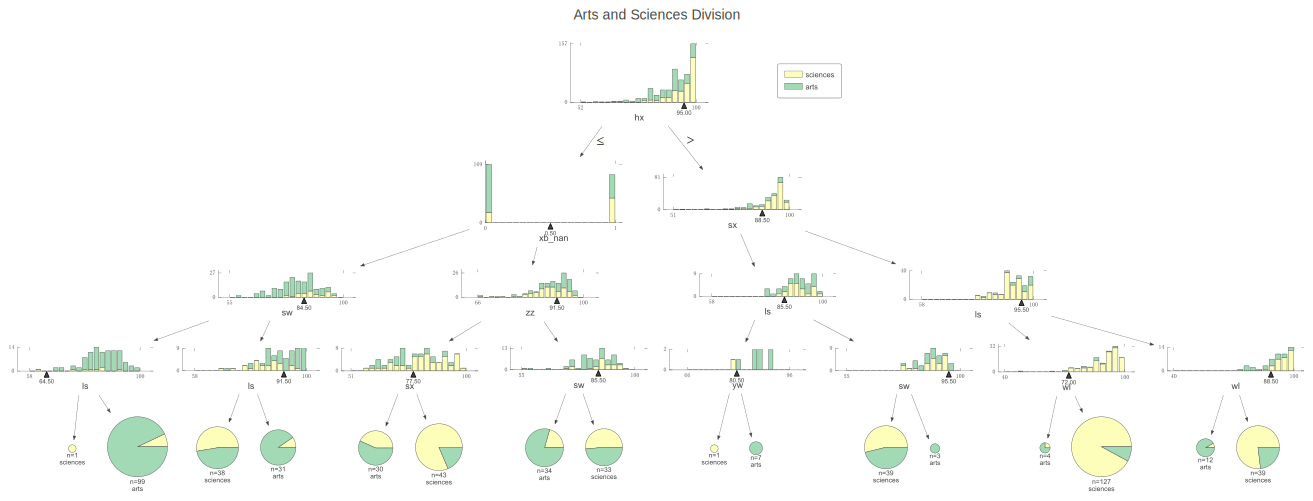

In [36]:
itree = dtreeviz(
    clf_dt,
    x_data=X_train,
    y_data=y_train,
    # target_name='wlfk',
    feature_names=X_train.columns,
    class_names=["sciences", "arts"],
    title="Arts and Sciences Division",
)
itree

突出显示某个测试样本的决策路径：

In [37]:
X_test

,yw,sx,wy,zz,ls,dl,wl,hx,sw,xb_nan,xb_nv
730,83,98,86,95,84,94,84,100,92,1,0
673,82,67,75,95,74,87,68,84,79,1,0
155,86,59,87,89,85,92,73,74,68,0,1
755,82,78,85,89,89,88,81,94,80,1,0
707,85,78,84,94,86,90,76,88,90,1,0
...,...,...,...,...,...,...,...,...,...,...,...
59,87,85,82,95,90,92,88,98,89,0,1
663,82,73,84,95,96,94,63,92,79,1,0
637,92,86,88,92,85,94,80,94,94,1,0
473,94,95,94,91,93,96,85,100,90,0,1


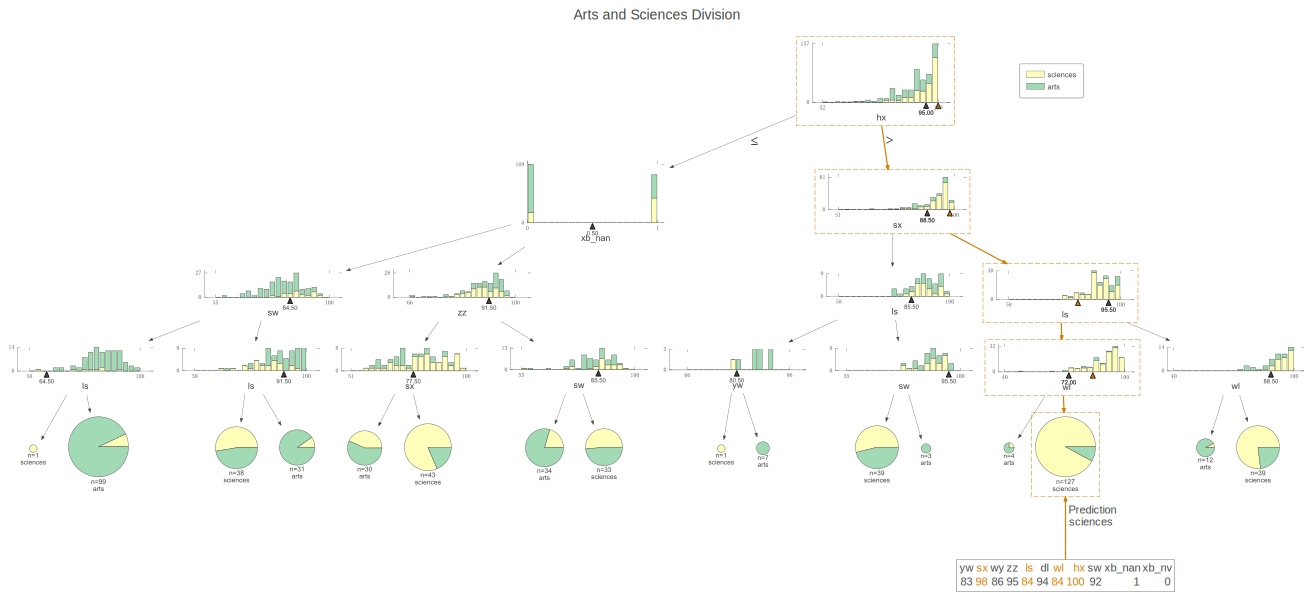

In [38]:
itree = dtreeviz(
    clf_dt,
    x_data=X_train,
    y_data=y_train,
    # target_name='wlfk',
    feature_names=X_train.columns,
    class_names=["sciences", "arts"],
    title="Arts and Sciences Division",
    X=X_test.iloc[0, :],
)
itree

In [39]:
print(
    explain_prediction_path(
        clf_dt,
        X_test.iloc[0, :],
        feature_names=X_train.columns,
        explanation_type="plain_english",
    )
)

88.5 <= sx 
ls < 95.5
72.0 <= wl 
95.0 <= hx 



AxesSubplot(0.125,0.125;0.775x0.775)


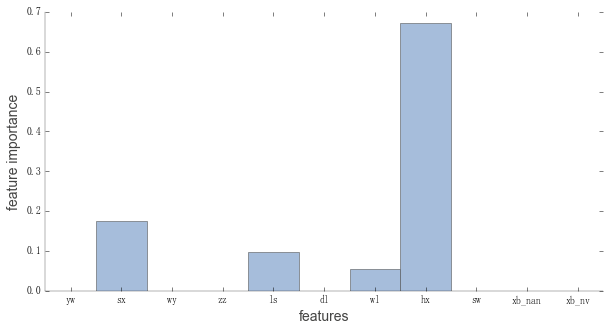

In [40]:
print(
    explain_prediction_path(
        clf_dt,
        X_test.iloc[0, :],
        feature_names=X_train.columns,
        explanation_type="sklearn_default",
    )
)

注意：执行dtreeviz相关代码前，请安装GraphViz，并在环境变量PATH中增加C:\Program Files\Graphviz\bin

可以看看混淆矩阵：

Accuracy:  0.7068965517241379


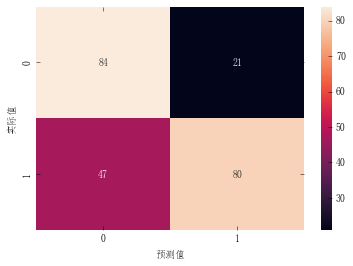

In [41]:
cm = pd.crosstab(y_test, y_test_pred_dt, rownames=["实际值"], colnames=["预测值"])
print("Accuracy: ", accuracy_score(y_test, y_test_pred_dt))
_ = sns.heatmap(cm, annot=True)

当然，也可以不必重复造轮子，这些常规操作在sklearn中都有实现：

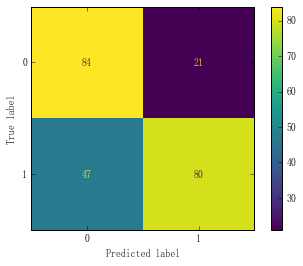

In [42]:
# Plot the confusion matrix in graph
cm = confusion_matrix(y_test, y_test_pred_dt, labels=clf_dt.classes_)

# ploting with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_dt.classes_)
disp.plot()

In [43]:
param_grid = {
    "criterion": ["entropy", "gini"],
    "max_depth": [2, 4, 6, 8, 10],
    "min_samples_split": [1, 2, 4, 8, 12, 16, 20],
}
clf_dt2 = tree.DecisionTreeClassifier()  # 定义一棵树
clfcv_dt = GridSearchCV(estimator=clf_dt2, param_grid=param_grid, scoring="accuracy", cv=5)
clfcv_dt.fit(X=X_train, y=y_train)
y_test_pred_cv_dt = clfcv_dt.predict(X_test)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [2, 4, 6, 8, 10],
                         'min_samples_split': [1, 2, 4, 8, 12, 16, 20]},
             scoring='accuracy')

In [44]:
accuracy_score(y_test, y_test_pred_cv_dt)

0.6896551724137931

In [45]:
clfcv_dt.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_split=12)

In [46]:
clfcv_dt.best_score_

0.7190282025144411

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

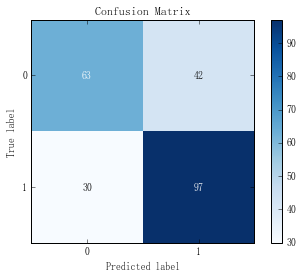

In [47]:
skplt.metrics.plot_confusion_matrix(y_test, y_test_pred_cv_dt, normalize=False)
plt.show()

In [48]:
y_pred_prob_cv_dt = clfcv_dt.predict_proba(X_test)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

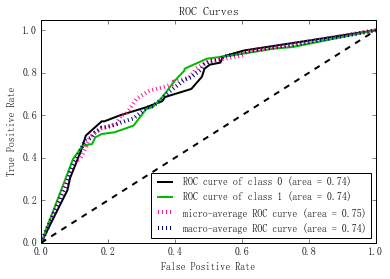

In [49]:
skplt.metrics.plot_roc(y_test, y_pred_prob_cv_dt)

## 随机森林

一棵决策树可以学到很复杂的规则。然而，很可能会导致过拟合问题——学到的规则只适用于训练集。解决方法之一就是调整决策树算法，限制它所学到的规则的数量。例如，把决策树的深度限制在三层，只让它学习从全局角度拆分数据集的最佳规则，不让它学习适用面很窄的特定规则，这些规则会将数据集进一步拆分为更加细致的群组。使用这种折中方案得到的决策树泛化能力强，但整体表现稍弱。  
为了弥补上述方法的不足，我们可以创建多棵决策树，用它们分别进行预测，再根据少数服从多数的原则从多个预测结果中选择最终预测结果。这正是随机森林的工作原理。

设：给定$d$个元组的训练集$D$，为组合分类器产生$k$棵决策树
* (1)使用有放回抽样生成训练集$D_i$，每个$D_i$都是$D$的一个自助样本，某些元组在$D_i$中出现多次，而某些元组不出现
* (2)每个自助样本集生长为单棵分类树（随机选取分裂属性集）：设$F$是用来在每个节点决定划分的属性数，其中$F$远小于可用属性数。为构造决策树分类器$M_i$，在每个节点随机选择$F$个属性作为该节点划分的候选属性。使用CART方法增长树，增长到最大规模且不剪枝
* (3) 采用简单多数投票法得到随机森林的结果

<img src=figtabs/ch5/random_forest.png align=left width = 60% height = 60% />

scikit-learn 库中的 RandomForestClassifier 就是对随机森林算法的实现，它提供了一系列参数。因为它使用了 DecisionTreeClassifier 的大量实例，所以它俩的很多参数是一致的，比如决策标准（基尼不纯度/信息增益）、 max_features 和 min_samples_split 。
当然，集成过程还引入了一些新参数：  
* n_estimators ：用来指定创建决策树的数量。该值越高，所花时间越长，正确率（可能）也越高。  
* oob_score ：如果设置为真，测试时将不使用训练模型时用过的数据  
* n_jobs ：采用并行计算方法训练决策树时所用到的内核数量。

In [50]:
clf_rf = RandomForestClassifier(criterion="gini", n_estimators=1000, random_state=rng)
clf_rf.fit(X_train, y_train)
y_test_pred_rf = clf_rf.predict(X_test)
print_performance(y_test, y_test_pred_rf)

RandomForestClassifier(n_estimators=1000,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

误分样本数（Misclassified samples）: 48
准确率(accuracy): 79.31%


可以尝试一下决策树数量对模型性能的影响：

In [51]:
accuracy_lst = []
ntrees = range(50, 5500, 100)
for ntree in ntrees:
    clf_tmp_rf = RandomForestClassifier(
        criterion="gini", n_estimators=ntree, random_state=rng
    )
    clf_tmp_rf.fit(X_train, y_train)
    y_test_pred_tmp_rf = clf_tmp_rf.predict(X_test)
    accuracy_lst.append(accuracy_score(y_test, y_test_pred_tmp_rf))

RandomForestClassifier(n_estimators=50,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=150,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=250,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=350,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=450,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=550,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=650,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=750,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=850,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=950,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=1050,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=1150,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=1250,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=1350,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=1450,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=1550,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=1650,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=1750,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=1850,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=1950,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=2050,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=2150,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=2250,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=2350,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=2450,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=2550,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=2650,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=2750,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=2850,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=2950,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=3050,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=3150,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=3250,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=3350,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=3450,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=3550,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=3650,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=3750,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=3850,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=3950,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=4050,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=4150,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=4250,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=4350,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=4450,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=4550,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=4650,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=4750,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=4850,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=4950,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=5050,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=5150,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=5250,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=5350,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

RandomForestClassifier(n_estimators=5450,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

In [52]:
accuracy_lst = np.array(accuracy_lst)

In [53]:
accuracy_max, ntree_max = accuracy_lst.max(), ntrees[accuracy_lst.argmax()]

In [54]:
ntree_max

850

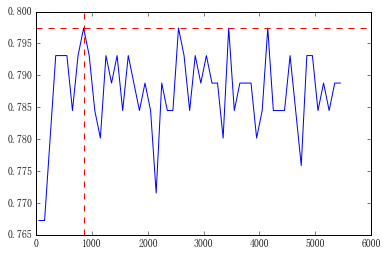

In [55]:
plt.plot(ntrees, accuracy_lst)
plt.axhline(accuracy_max, color="red", linestyle="dashed")
plt.axvline(ntree_max, color="red", linestyle="dashed")
plt.show()

In [56]:
ntree_max = 350

In [57]:
clf_rf_optimal = RandomForestClassifier(
    criterion="gini", n_estimators=ntree_max, random_state=rng
)
clf_rf_optimal.fit(X_train, y_train)
y_test_pred_rf_optimal = clf_rf_optimal.predict(X_test)
y_test_pred_prob_rf_optimal = clf_rf_optimal.predict_proba(X_test)

RandomForestClassifier(n_estimators=350,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

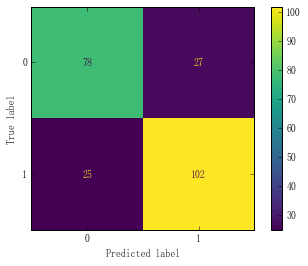

In [58]:
# Plot the confusion matrix in graph
cm = confusion_matrix(y_test, y_test_pred_rf_optimal, labels=clf_rf_optimal.classes_)

# ploting with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_rf_optimal.classes_)
disp.plot()

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

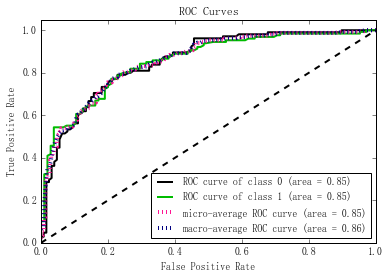

In [59]:
skplt.metrics.plot_roc(y_test, y_test_pred_prob_rf_optimal )

## 朴素贝叶斯

先看一下贝叶斯公式:<br>
$p\left( {y|{X_1},{X_2}, \cdots ,{X_n}} \right) = \frac{{p\left( {{X_1},{X_2}, \cdots ,{X_n}|y} \right)p\left( y \right)}}{{p\left( {{X_1},{X_2}, \cdots ,{X_n}} \right)}}$

分母不发挥作用：<br>
$p\left( {y|{X_1},{X_2}, \cdots ,{X_n}} \right) = \frac{{p\left( {{X_1},{X_2}, \cdots ,{X_n}|y} \right)p\left( y \right)}}{{p\left( {{X_1},{X_2}, \cdots ,{X_n}} \right)}} \propto p\left( {{X_1},{X_2}, \cdots ,{X_n}|y} \right)p\left( y \right)$

朴素一点：<br>
$p\left( {y|{X_1},{X_2}, \cdots ,{X_n}} \right) \propto p\left( {{X_1},{X_2}, \cdots ,{X_n}|y} \right)p\left( y \right) = p\left( y \right)\prod\limits_{j = 1}^n {p\left( {{X_j}|y} \right)}$

用于分类：<br>
$classify\left( {{X_1},{X_2}, \cdots ,{X_n}} \right) = \mathop {\arg \max }\limits_c p\left( {y = c} \right)\prod\limits_{j = 1}^n {p\left( {{X_j}|y = c} \right)}$

In [60]:
clf_nb = GaussianNB()
clf_nb.fit(X_train, y_train)
y_test_pred_nb = clf_nb.predict(X_test)

GaussianNB()

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

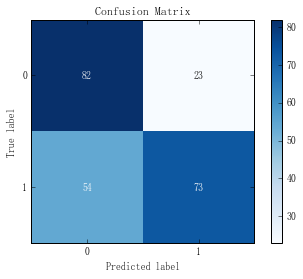

In [61]:
skplt.metrics.plot_confusion_matrix(y_test, y_test_pred_nb, normalize=False)
plt.show()

In [62]:
y_test_pred_prob_nb = clf_nb.predict_proba(X_test)
print_performance(y_test, y_test_pred_nb)

误分样本数（Misclassified samples）: 77
准确率(accuracy): 66.81%


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

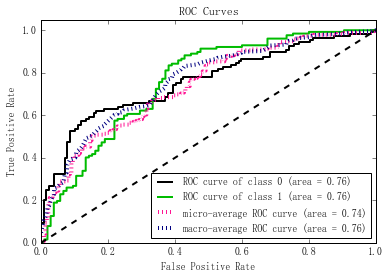

In [63]:
skplt.metrics.plot_roc(y_test, y_test_pred_prob_nb)
plt.show()

## 逻辑斯蒂回归

要综合利用好属性、特征信息，一个简单的办法是把他们“加”起来：  
$z = info\left( x \right) = {w_0} + {w_1}{x_1} +  \cdots  + {w_m}{x_m}$  
我们的目标：  
$info\left( x \right) \to \left[ {0,1} \right]$

令：  
$p\left( {y = 1|x} \right) = \frac{1}{{1 + {e^{ - info\left( x \right)}}}} = \frac{1}{{1 + {e^{ - z}}}} = \phi \left( z \right) \in \left[ {0,1} \right]$

我们定义事件发生比odd ratio:$\frac{p}{{1 - p}}$。其中$p$为正事件发生的概率。此处，正事件并不意味着好的事件，而是指我们所要预测的事件，以一个患者患有某种疾病的概率为例，我们可以将正事件的类标标记为$y＝1$。更进一步，我们可以定义logit函数，它是几率比的对数函数（log-odds，对数几率）：  
$logit\left( p \right) = \log \left( {\frac{p}{{1 - p}}} \right)$

$logit\left( {p\left( {y = 1|x} \right)} \right) = {w_0}{x_0} + {w_1}{x_1} +  \cdots  + {w_p}{x_p} = \sum\limits_{j = 0}^p {{w_j}{x_j}}  = {w^T}x$  
即：$\ln \left( {odd} \right) = \ln \frac{{p\left( {y = 1|x} \right)}}{{1 - p\left( {y = 1|x} \right)}} = z = info\left( x \right)$

我们可以通过极大似然函数：  
$\begin{array}{l}
l\left( w \right) = \ln L\left( w \right) = \ln \left( {\prod\limits_{i = 1}^m {p{{\left( {{y_i}|{x^{(i)}}} \right)}^{{y_i}}}{{\left( {1 - p\left( {{y_i}|{x^{(i)}}} \right)} \right)}^{1 - {y_i}}}} } \right)\\
\;\;\;\;\;\;\; = \ln \left( {\prod\limits_{i = 1}^m {\phi {{\left( {{z^{(i)}}} \right)}^{{y_i}}}{{\left( {1 - \phi \left( {{z^{(i)}}} \right)} \right)}^{1 - {y_i}}}} } \right)\\
\;\;\;\;\;\;\; = \sum\limits_{i = 1}^m {\left( {{y_i}\ln \left( {\phi \left( {{z^{(i)}}} \right)} \right) + \left( {1 - {y_i}} \right)\ln \left( {1 - \phi \left( {{z^{(i)}}} \right)} \right)} \right)} 
\end{array}$

推导得出代价函数：  
$J\left( w \right) = \sum\limits_{i = 1}^m { - {y_i}\log \left( {\phi \left( {{z^{(i)}}} \right)} \right) - \left( {1 - {y_i}} \right)\log \left( {1 - \phi \left( {{z^{(i)}}} \right)} \right)}$

进一步地，通过正则化解决过拟合问题：  

正则项：  
$L2:\left\| w \right\|_2^2 = \sum\limits_{j = 1}^m {w_j^2}$


$L1:{\left\| w \right\|_1} = \sum\limits_{j = 1}^m {\left| {{w_j}} \right|}$

其中的参数$C$为了与支持向量机保持一致，是正则化系数的倒数：  
$C = \frac{1}{\lambda }$
逻辑斯蒂回归中的正则化代价函数写作：  
$J\left( w \right) = C\left\{ {\sum\limits_{i = 1}^m { - {y_i}\log \left( {\phi \left( {{z^{(i)}}} \right)} \right) - \left( {1 - {y_i}} \right)\log \left( {1 - \phi \left( {{z^{(i)}}} \right)} \right)} } \right\} + \frac{1}{2}{\left\| w \right\|^2}$

In [64]:
clf_lr = LogisticRegression(C=100.0, random_state=rng)
clf_lr.fit(X_train, y_train)
y_test_pred_lr = clf_lr.predict(X_test)
print_performance(y_test, y_test_pred_lr)

LogisticRegression(C=100.0, random_state=RandomState(MT19937) at 0x2A7D3A09140)

误分样本数（Misclassified samples）: 53
准确率(accuracy): 77.16%


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

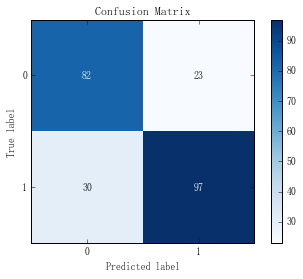

In [65]:
skplt.metrics.plot_confusion_matrix(y_test, y_test_pred_lr, normalize=False)
plt.show()

In [66]:
y_test_pred_prob_lr = clf_lr.predict_proba(X_test)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

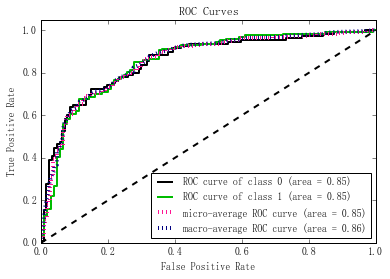

In [67]:
skplt.metrics.plot_roc(y_test, y_test_pred_prob_lr)
plt.show()

对于scikit-learn中支持L1的正则化模型，我们可以通过将penalty参数设定为‘l1’,

In [68]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [69]:
clf_lr2 = LogisticRegression()
clf_lr2.fit(X_train_pca, y_train)

LogisticRegression()

In [70]:
print_performance(y_test, clf_lr2.predict(X_test_pca))

误分样本数（Misclassified samples）: 81
准确率(accuracy): 65.09%


<AxesSubplot:>

Text(0.5, 0, 'PC 1')

Text(0, 0.5, 'PC 2')

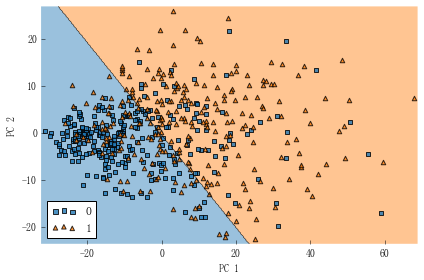

In [71]:
plot_decision_regions(X_train_pca, y_train, clf=clf_lr2)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(loc="lower left")
plt.tight_layout()
# plt.savefig('./figures/pca3.png', dpi=300)
plt.show()

## 人工神经网络

所谓的复杂，往往由简单的事物通过简单的方式组合而成。比如人工神经网络：

<img src=figtabs/ch5/ann1.png align=left width = 50%/>

其前向输出可表示为：  
${y_r} = f\left( {\sum\limits_{s = 1}^{{n_{L - 2}}} {w_{sr}^{l = L - 1} \cdots f\left( {w_{jk}^{l = 2}f\left( {\sum\limits_{i = 1}^n {w_{ij}^{l = 1}{x_i}} } \right)} \right)} } \right),r = 1,2, \cdots ,m$

用一个更简单的图，来表示其训练过程：

<img src=figtabs/ch5/ann2.png align=left width = 50%/>

学习策略——最小化误差平方和：

$E\left( w \right) = \frac{1}{2}\sum\limits_{d \in D} {{{\left( {{t_d} - {o_d}} \right)}^2}} $

迭代过程：  
$\begin{array}{l}
w\left( {t + 1} \right) = w\left( t \right) - \lambda \Delta E\left( w \right)\\
\Delta E\left( w \right) = \left[ {\frac{{\partial E}}{{\partial {w_0}}},\frac{{\partial E}}{{\partial {w_1}}}, \cdots ,\frac{{\partial E}}{{\partial {w_N}}}} \right]
\end{array}$

对于连接输出层的权值：

<img src=figtabs/ch5/ann_bp_01.png align=left width = 50%/>

对于其他层权值的调整：

<img src=figtabs/ch5/ann_bp_02.png align=left width = 50%/>

<img src=figtabs/ch5/ann_bp_03.png align=left width = 50%/>

BP算法描述：

<img src=figtabs/ch5/ann_bp_04.png align=left width = 50%/>

In [72]:
clf_mlp = MLPClassifier(activation='logistic', hidden_layer_sizes=(15), random_state=2012)
clf_mlp.fit(X_train, y_train)
y_test_pred_mlp = clf_mlp.predict(X_test)
print_performance(y_test, y_test_pred_mlp)

MLPClassifier(activation='logistic', hidden_layer_sizes=15, random_state=2012)

误分样本数（Misclassified samples）: 54
准确率(accuracy): 76.72%


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

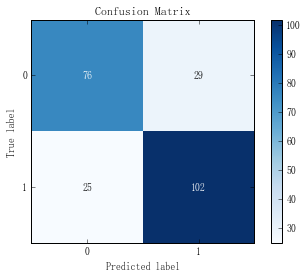

In [73]:
skplt.metrics.plot_confusion_matrix(y_test,y_test_pred_mlp, normalize=False)
plt.show()

In [74]:
y_test_pred_prob_mlp = clf_mlp.predict_proba(X_test)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

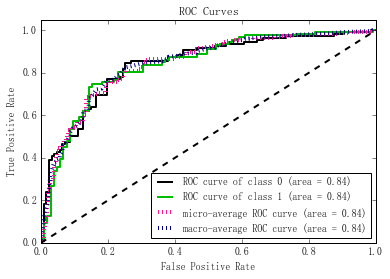

In [75]:
skplt.metrics.plot_roc(y_test, y_test_pred_prob_mlp)
plt.show()

In [76]:
param_grid = {
    "hidden_layer_sizes": [(x) for x in [5, 10, 30, 50, 100, 500]]
}
clf_mlp2 = MLPClassifier(activation='logistic', max_iter=2000, random_state=2012)
clfcv_mlp = GridSearchCV(estimator=clf_mlp2, param_grid=param_grid, scoring="accuracy", cv=5)
clfcv_mlp.fit(X=X_train, y=y_train)
y_test_pred_cv_mlp = clfcv_mlp.predict(X_test)
y_test_pred_prob_cv_mlp = clfcv_mlp.predict_proba(X_test)

GridSearchCV(cv=5,
             estimator=MLPClassifier(activation='logistic', max_iter=2000,
                                     random_state=2012),
             param_grid={'hidden_layer_sizes': [5, 10, 30, 50, 100, 500]},
             scoring='accuracy')

In [77]:
clfcv_mlp.best_estimator_

MLPClassifier(activation='logistic', hidden_layer_sizes=30, max_iter=2000,
              random_state=2012)

In [78]:
accuracy_score(y_test, y_test_pred_cv_mlp)

0.7758620689655172

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

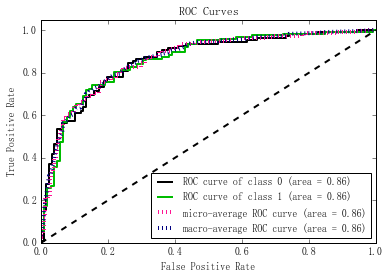

In [79]:
skplt.metrics.plot_roc(y_test, y_test_pred_prob_cv_mlp)
plt.show()

<AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score'>

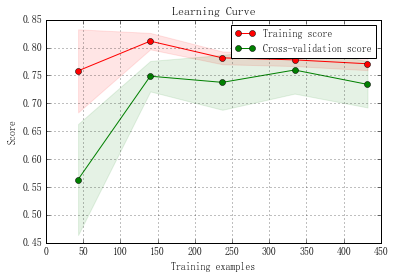

In [80]:
skplt.estimators.plot_learning_curve(clf_mlp, X_train, y_train)

For more details: https://scikit-learn.org/stable/modules/neural_networks_supervised.html

## 支持向量机

支持向量机首先涉及到分类超平面的概念。以下分别是一维、二维、三维空间中的超平面<br>
<img src=figtabs/ch5/svm_hyperplane.png align=left width=75%/> 

显然，他们都有共同的形式：<br>
${w^T}x = 0$

🌈🌈🌈🌈  **Time to Play**  ✨✨✨✨

空间中某个点$x$到超平面${w^T}x + b = 0$的距离是多少？

<img src=figtabs/ch5/svm_distance.png align=left width=50%/>

$\begin{array}{l}
{w^T}x + b = {w^T}\left( {{x_p} + r\frac{w}{{\left\| w \right\|}}} \right) + b = {w^T}{x_p} + r\frac{{{w^T}w}}{{\left\| w \right\|}} + b = r\left\| w \right\|\\
 \Rightarrow \left| r \right| = \frac{{\left| {{w^T}x + b} \right|}}{{\left\| w \right\|}}
\end{array}$

要将数据点分开，有很多这样的超平面。相比较而言，下图中红色的部分有更宽的边缘，“道路”更宽、泛化能力更强<br>
<img src=figtabs/ch5/svm_margin.png align=left width=50%/>

这个边缘怎么表示呢：<br>
令两个平行的边界分别为：<br>
${w^T}x + b = 1$<br>
${w^T}x + b = -1$<br>
于是有：<br>
$\begin{array}{l}
{w^T}\left( {{p_1} - {p_2}} \right) = 2\\
 \Rightarrow \left\| w \right\| \times d = 2\\
 \Rightarrow d = \frac{2}{{\left\| w \right\|}}
\end{array}$<br>
<img src=figtabs/ch5/svm_margin2.png align=left width=50%/>

可能有小伙伴对令两侧边界为1和-1感到疑惑，道理其实也比较简单：  
$\begin{array}{*{20}{c}}
{\mathop {\arg \max }\limits_{w,b} \mathop {\arg \min }\limits_x \frac{{\left| {{w^T}x + b} \right|}}{{\left\| w \right\|}}\;\;\;\;\;s.t.\;\;{y_i}\left( {{w^T}x + b} \right) > 0}\\
 \Updownarrow \\
{\mathop {\arg \min }\limits_{w,b} \frac{{\left\| w \right\|}}{2}\;\;\;\;\;s.t.\;\;{y_i}\left( {{w^T}x + b} \right) \ge 1}
\end{array}$

实现间隔最大化，等价于最小化目标函数：<br>
$\mathop {\min }\limits_w \frac{{{{\left\| w \right\|}^2}}}{2}$<br>
满足如下约束：<br>
${y_i}\left( {{w^T}x + b} \right) \ge 1$<br>
通过拉格朗日法求解，得到权向量最优解为：<br>
${w^*} = \sum\limits_{i = 1}^m {\alpha _i^*{y_i}{x^{\left( i \right)}}}$<br>
相应的决策函数为：<br>
${w^*}{x^{\left( j \right)}} + b = {\left( {\sum\limits_{i = 1}^m {\alpha _i^*{y_i}{x^{\left( i \right)}}} } \right)^T}{x^{\left( j \right)}} + b = \sum\limits_{i = 1}^m {\alpha _i^*{y_i}\left\langle {{x^{\left( i \right)}},{x^{\left( j \right)}}} \right\rangle }  + b$<br>
由此可以看出：对于测试集的预测，只需要计算它与训练数据点的内积即可；准确地讲，是只需要计算它和支持向量的内积即可，因为非支持向量的$\alpha$均为零

<img src=figtabs/ch5/svm_softmargin.png align=left width=50%/>

对比上图中的两个超平面。红色的超平面，错分了一个样本，蓝色的超平面完全正确。但是，红色道路依然比蓝色的道路更可取，软间隔soft margin学习允许一定训练错误的决策边界

在数学上，相当于是引入了松弛变量：<br>
$\begin{array}{l}
{w^T}{x^{(i)}} + b = 1 - {\xi _i},{y_i} = 1\\
{w^T}{x^{(i)}} + b = {\rm{ - }}1 + {\xi _i},{y_i} =  - 1
\end{array}$<br>
相应的目标函数为：<br>
$\frac{{{{\left\| w \right\|}^2}}}{2} + C{\left( {\sum\limits_{i = 1}^N {{\xi _i}} } \right)^k}$

以上都是线性可分的情况，也可能存在如下线性不可能的情形：<br>
<img src=figtabs/ch5/svm_nonlinear.png align=left width=50%/>

对于非线性问题，需要做到：<br>
* 第一，将属性空间映射到特征空间；
* 第二，在特征空间中采用线性分类器进行分类。<br>


<img src=figtabs/ch5/svm_01.png align=left width=50%/>

<img src=figtabs/ch5/svm_02.png align=left width=50%/>

<img src=figtabs/ch5/svm_03.png align=left width=50%/>

决策规则为：<br>
$\sum\limits_{i = 1}^m {\alpha _i^*{y_i}\left\langle {\phi \left( {{x^{\left( i \right)}}} \right),{x^{\left( j \right)}}} \right\rangle }  + b$<br>
其中，$\phi$为属性空间到特征空间的映射：$\phi :{\cal X} \to {\cal F}$<br>
引入核方法：<br>
一对向量的核函数等于变换后空间中计算这对向量的内积：$K\left( {{x^{\left( i \right)}},{x^{\left( j \right)}}} \right) = \left\langle {\phi \left( {{x^{\left( i \right)}}} \right),\phi \left( {{x^{\left( j \right)}}} \right)} \right\rangle $<br>
也就是说，有了核函数，我们甚至不需要知道如何具体映射到高维空间

更具体而言：  
* 训练过程   

$\begin{array}{*{20}{c}}
\begin{array}{l}
\mathop {\max }\limits_\alpha  Q\left( \alpha  \right) = \sum\limits_{i = 1}^N {{\alpha _i}}  - \frac{1}{2}\sum\limits_{i,j = 1}^N {{\alpha _i}{\alpha _j}{y_i}{y_j}\left\langle {\varphi \left( {{x_i}} \right),\varphi \left( {{x_j}} \right)} \right\rangle } \\
s.t.\;\;\;\sum\limits_{i = 1}^N {{y_i}{\alpha _i}}  = 0\;\;\;\;\;\;0 \le {\alpha _i} \le C\;\;\;\;\;\;i = 1,2, \cdots ,N
\end{array}\\
 \downarrow \\
\begin{array}{l}
\mathop {\max }\limits_\alpha  Q\left( \alpha  \right) = \sum\limits_{i = 1}^N {{\alpha _i}}  - \frac{1}{2}\sum\limits_{i,j = 1}^N {{\alpha _i}{\alpha _j}{y_i}{y_j}K\left( {{x_i},{x_j}} \right)} \\
s.t.\;\;\;\sum\limits_{i = 1}^N {{y_i}{\alpha _i}}  = 0\;\;\;\;\;\;0 \le {\alpha _i} \le C\;\;\;\;\;\;i = 1,2, \cdots ,N
\end{array}
\end{array}$

* 测试过程

$f\left( x \right) = {\mathop{\rm sgn}} \left\{ {\sum\limits_{i = 1}^N {\alpha _i^*{y_i}\left\langle {\varphi \left( {{x_i}} \right),\varphi \left( {{x_j}} \right)} \right\rangle }  + {b^*}} \right\} = {\mathop{\rm sgn}} \left\{ {\sum\limits_{i = 1}^N {\alpha _i^*{y_i}K\left( {{x_i},x} \right)}  + {b^*}} \right\}$

In [81]:
clf_svm = SVC(kernel="linear", C=1.0, random_state=rng)
clf_svm.fit(X_train, y_train)
y_test_pred_svm = clf_svm.predict(X_test)
print_performance(y_test, y_test_pred_svm)

SVC(kernel='linear', random_state=RandomState(MT19937) at 0x2A7D3A09140)

误分样本数（Misclassified samples）: 57
准确率(accuracy): 75.43%


In [82]:
clf_svm2 = SVC(kernel="rbf", gamma=0.003, C=1.0, random_state=rng, probability=True)
clf_svm2.fit(X_train, y_train)
y_test_pred_svm2 = clf_svm2.predict(X_test)
print_performance(y_test, y_test_pred_svm2)

SVC(gamma=0.003, probability=True,
    random_state=RandomState(MT19937) at 0x2A7D3A09140)

误分样本数（Misclassified samples）: 51
准确率(accuracy): 78.02%


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

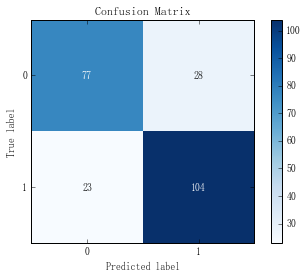

In [83]:
skplt.metrics.plot_confusion_matrix(y_test,y_test_pred_svm2, normalize=False)
plt.show()

In [84]:
y_test_pred_prob_svm2 = clf_svm2.predict_proba(X_test)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

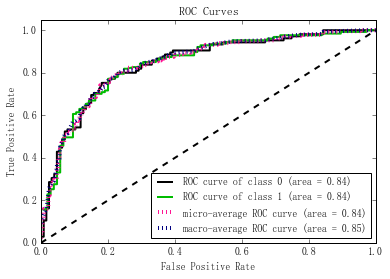

In [85]:
skplt.metrics.plot_roc(y_test, y_test_pred_prob_svm2)
plt.show()

## 参数调优——格子点搜索

参数的设置，当然可以自己写嵌套循环来实现，不过更好的办法，是采用格子点搜索：

In [86]:
parameter_space = {
    "n_estimators": [500, 1000, 1500, 2000],
    "criterion": ["gini", "entropy"],
}
clf = RandomForestClassifier(random_state=rng)
grid = GridSearchCV(clf, parameter_space)
grid.fit(X_train, y_train)
print("Accuracy: {0:.2f}%".format(grid.best_score_ * 100))

GridSearchCV(estimator=RandomForestClassifier(random_state=RandomState(MT19937) at 0x2A7D3A09140),
             param_grid={'criterion': ['gini', 'entropy'],
                         'n_estimators': [500, 1000, 1500, 2000]})

Accuracy: 76.16%


In [87]:
def wts1(distance):
    return 1 / distance


def wts2(distance):
    return np.exp(-distance)


parameter_space = {
    "n_neighbors": range(1, 30),
    "weights": ["uniform", "distance", wts1, wts2],
}
clf = KNeighborsClassifier()
grid = GridSearchCV(clf, parameter_space)
grid.fit(X_train, y_train)
print("Accuracy: {0:.2f}%".format(grid.best_score_ * 100))

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 30),
                         'weights': ['uniform', 'distance',
                                     <function wts1 at 0x000002A7D5CF00D0>,
                                     <function wts2 at 0x000002A7D5CF0040>]})

Accuracy: 77.09%


这次正确率提升较大，达到了77.27%！  
输出用网格搜索找到的最佳模型，查看都使用了哪些参数。代码如下：

In [88]:
print(grid.best_estimator_)

KNeighborsClassifier(n_neighbors=8, weights='distance')


可能也有同学会对自动优化参数比较感兴趣，也就是说为的机器学习自动化。可以自行查阅相关内容，比如研究一下autosklearn模块。

## K折交叉检验

K折交叉检验的原理如下：<br>
<img src=figtabs/ch5/k_fold.png align=center height=50% width=50% />

scikit-learn 库实现的随机森林算法使用估计器接口，用交叉检验方法调用它即可，代码跟之前大同小异。

In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from mlxtend.classifier import StackingClassifier

clf = RandomForestClassifier(random_state=rng)
cv5 = cross_val_score(clf, X_train, y_train, cv=5, scoring="accuracy")
cv10 = cross_val_score(clf, X_train, y_train, cv=10, scoring="accuracy")
print("Accuracy: {0:.1f}%".format(np.mean(cv5) * 100))
print("Accuracy: {0:.1f}%".format(np.mean(cv10) * 100))

Accuracy: 74.9%
Accuracy: 74.5%


In [90]:
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], meta_classifier=lr)

In [91]:
print("3-fold cross validation: \n")

for clf, label in zip(
    [clf1, clf2, clf3, sclf],
    ["KNN", "Random Forest", "Naive Bayes", "StackingClassifier"],
):
    scores = cross_val_score(
        clf, X_train, y_train, cv=3, scoring="accuracy"
    )
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

3-fold cross validation: 

Accuracy: 0.68 (+/- 0.03) [KNN]
Accuracy: 0.74 (+/- 0.04) [Random Forest]
Accuracy: 0.72 (+/- 0.02) [Naive Bayes]
Accuracy: 0.74 (+/- 0.03) [StackingClassifier]


## 模型存储

无论是数据清洗，还是建模，都要耗费一定的运行时间。清洗好的数据、以及建好的模型，我们希望可以直接存储起来，留待日后再用。在Python里边，通常的做法是把他们“腌制”起来，长期保存，方法和前述pickle X_numeric的方法一样。此外，joblib也是常用的一个模型持久化的包，可以方便地把模型存到磁盘上。

## 变量重要性

[变量重要性计算方法](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#overview)如下：<br>
* **Variable importance**<br>
> In every tree grown in the forest, put down the oob cases and count the number of votes cast for the correct class. Now randomly permute the values of variable m in the oob cases and put these cases down the tree. Subtract the number of votes for the correct class in the variable-m-permuted oob data from the number of votes for the correct class in the untouched oob data. The average of this number over all trees in the forest is the raw importance score for variable m.<br>
* **Gini importance**<br>
> Every time a split of a node is made on variable m the gini impurity criterion for the two descendent nodes is less than the parent node. Adding up the gini decreases for each individual variable over all trees in the forest gives a fast variable importance that is often very consistent with the permutation importance measure.

在sklearn中的实现：<br>
> The relative rank (i.e. depth) of a feature used as a decision node in a tree can be used to assess the relative importance of that feature with respect to the predictability of the target variable. Features used at the top of the tree contribute to the final prediction decision of a larger fraction of the input samples. The expected fraction of the samples they contribute to can thus be used as an estimate of the relative importance of the features. In scikit-learn, the fraction of samples a feature contributes to is combined with the decrease in impurity from splitting them to create a normalized estimate of the predictive power of that feature.

In [92]:
importances = clf_rf_optimal.feature_importances_
feature_labels = X_train.columns

In [93]:
importances

array([0.06520737, 0.13641573, 0.07340706, 0.07909326, 0.10820885,
       0.05754357, 0.13905096, 0.13239856, 0.14369776, 0.03212834,
       0.03284853])

In [94]:
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print(
        "%2d) %-*s %f" % (f + 1, 20, feature_labels[indices[f]], importances[indices[f]])
    )

 1) sw                   0.143698
 2) wl                   0.139051
 3) sx                   0.136416
 4) hx                   0.132399
 5) ls                   0.108209
 6) zz                   0.079093
 7) wy                   0.073407
 8) yw                   0.065207
 9) dl                   0.057544
10) xb_nv                0.032849
11) xb_nan               0.032128


In [95]:
featureImportances = pd.Series(importances).sort_values(ascending=False)

<AxesSubplot:>

Text(0.5, 0, '变量重要性')

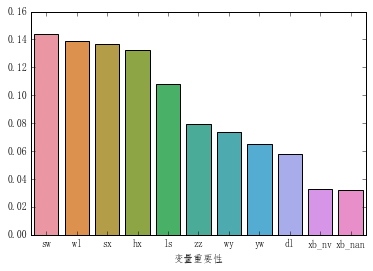

In [96]:
sns.barplot(x=feature_labels[indices], y=featureImportances)
plt.xlabel("变量重要性")
plt.show()

当然，采用scikitplot也可以：

<AxesSubplot:title={'center':'Feature Importance'}>

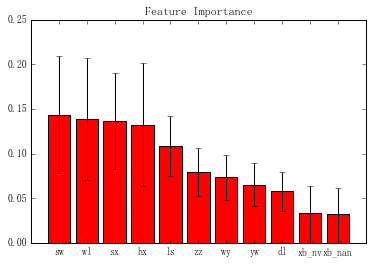

In [97]:
skplt.estimators.plot_feature_importances(clf_rf_optimal,  feature_names=X_train.columns)

## 不同分类器决策边界比较（仅取2个特征）

In [98]:
from mlxtend.classifier import EnsembleVoteClassifier
# Initializing Classifiers
clf1 = LogisticRegression(random_state=rng)
clf2 = RandomForestClassifier(random_state=rng)
clf3 = SVC(random_state=0, probability=True)
eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3], weights=[2, 1, 1], voting="soft")

In [99]:
list(itertools.product([0, 1], repeat=2))

[(0, 0), (0, 1), (1, 0), (1, 1)]

LogisticRegression(random_state=RandomState(MT19937) at 0x2A7D3A09140)

Text(0.5, 1.0, 'Logistic Regression')

RandomForestClassifier(random_state=RandomState(MT19937) at 0x2A7D3A09140)

Text(0.5, 1.0, 'Random Forest')

SVC(probability=True, random_state=0)

Text(0.5, 1.0, 'Naive Bayes')

EnsembleVoteClassifier(clfs=[LogisticRegression(random_state=RandomState(MT19937) at 0x2A7D3A09140),
                             RandomForestClassifier(random_state=RandomState(MT19937) at 0x2A7D3A09140),
                             SVC(probability=True, random_state=0)],
                       voting='soft', weights=[2, 1, 1])

Text(0.5, 1.0, 'Ensemble')

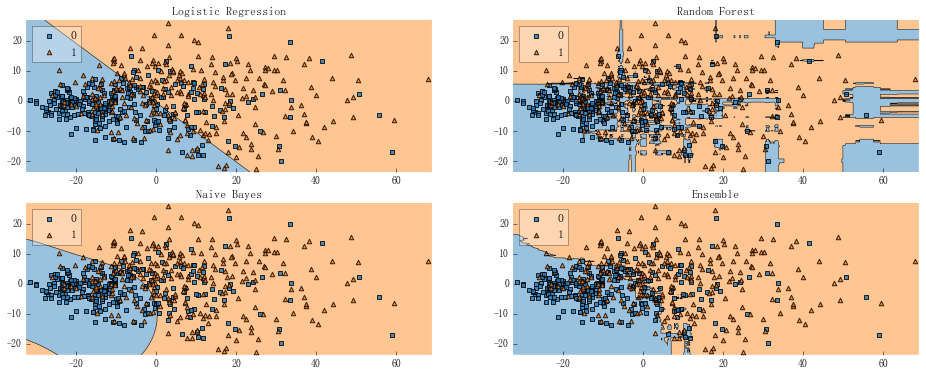

In [100]:
# Plotting Decision Regions
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(16, 6))

for clf, lab, grd in zip(
    [clf1, clf2, clf3, eclf],
    ["Logistic Regression", "Random Forest", "Naive Bayes", "Ensemble"],
    itertools.product([0, 1], repeat=2),
):
    clf.fit(X_train_pca, y_train)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_train_pca, y=y_train, clf=clf, legend=2)
    plt.title(lab)
plt.show()

## 不同分类器决策边界比较（取多个特征）

In [101]:
from sklearn.decomposition import PCA

PCA()

<AxesSubplot:title={'center':'PCA Component Explained Variances'}, xlabel='First n principal components', ylabel='Explained variance ratio of first n components'>

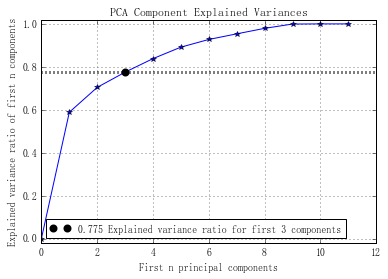

In [102]:
pca = PCA()
pca.fit(X_train)
skplt.decomposition.plot_pca_component_variance(pca)

<AxesSubplot:title={'center':'PCA 2-D Projection'}, xlabel='First Principal Component', ylabel='Second Principal Component'>

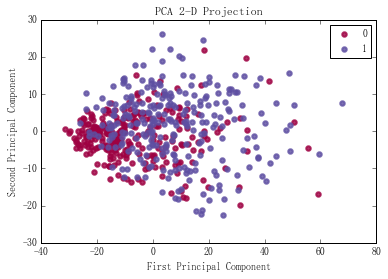

In [103]:
skplt.decomposition.plot_pca_2d_projection(pca, X_train, y_train)

In [104]:
def get_pca(X):
    pca = PCA(n_components=2)
    pca.fit(X)
    X_pca = pca.transform(X)
    X_pca = pd.DataFrame(X_pca)
    X_pca.columns = ["pc1", "pc2"]
    return X_pca

In [105]:
def get_data_frame_cartesian_product(df):
    dicts = df.to_dict(orient="list")
    new_list = [list(x) for x in itertools.product(*dicts.values())]
    new_df = pd.DataFrame(new_list, columns=df.columns)
    return new_df

In [106]:
test_df = pd.DataFrame({"x1": range(1, 4), "x2": ["a", "b", "c"]})
test_df.to_dict(orient="list").values()

dict_values([[1, 2, 3], ['a', 'b', 'c']])

In [107]:
# get_data_frame_cartesian_product(test_df)
[list(x) for x in itertools.product([1, 2, 3], ["a", "b", "c"])]

[[1, 'a'],
 [1, 'b'],
 [1, 'c'],
 [2, 'a'],
 [2, 'b'],
 [2, 'c'],
 [3, 'a'],
 [3, 'b'],
 [3, 'c']]

In [108]:
def plot_decision_regions2(X, y, clf, cp_flag=False, predict_proba=False):

    X = pd.DataFrame(X)

    if cp_flag:
        # 根据最大值、最小值生成等距栅格
        fill_ratio = 5  # 最大不要超过5
        col = 0
        col_min = np.min(X.iloc[:, col])
        col_max = np.max(X.iloc[:, col])
        X_simulation = [np.linspace(col_min, col_max, fill_ratio)]
        for col in X.columns[1:]:
            col_min = np.min(X.loc[:, col])
            col_max = np.max(X.loc[:, col])
            X_simulation.append(np.linspace(col_min, col_max, fill_ratio))
        X_simulation = pd.DataFrame(X_simulation).T
        X_simulation.columns = X.columns

        # 生成笛卡尔积DataFrame
        X_simulation_cartesian_product = get_data_frame_cartesian_product(X_simulation)

        X_train = pd.concat([X, X_simulation_cartesian_product], axis=0)
    else:
        X_train = X
    # 在笛卡尔数据框上进行预测
    y_train_pred = clf.predict(X_train)

    # 笛卡尔数据框的主成分
    X_train_pca = get_pca(X_train)

    # 原始数据的主成分
    X_pca = get_pca(X.values)

    # 主成分网格坐标
    x_min = np.min(X_pca.loc[:, "pc1"])
    x_max = np.max(X_pca.loc[:, "pc1"])
    y_min = np.min(X_pca.loc[:, "pc2"])
    y_max = np.max(X_pca.loc[:, "pc2"])
    xnum = 50
    ynum = 50
    dim = 2
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, num=xnum), np.linspace(y_min, y_max, num=ynum)
    )
    X_pca_grid = np.array([xx.ravel(), yy.ravel()]).T
    X_test = np.zeros((X_pca_grid.shape[0], dim))
    X_test[:, 0] = X_pca_grid[:, 0]
    X_test[:, 1] = X_pca_grid[:, 1]

    # 主成分网格相应的预测值——最近邻法
    model = KNeighborsClassifier(n_neighbors=1, weights="uniform")
    model.fit(X_train_pca, y_train_pred)
    if predict_proba:
        y_test_pred = model.predict_proba(X_test)
        y_test_pred = pd.DataFrame(y_test_pred).iloc[:, 1].values
    else:
        y_test_pred = model.predict(X_test)

    Z = y_test_pred.reshape(xx.shape)

    # 绘制决策边界
    markers = "s^oxv<>"
    colors = (
        "#1f77b4,#ff7f0e,#3ca02c,#d62728,"
        "#9467bd,#8c564b,#e377c2,"
        "#7f7f7f,#bcbd22,#17becf"
    )
    scatter_kwargs = None
    contourf_kwargs = None
    scatter_highlight_kwargs = None

    marker_gen = cycle(list(markers))

    n_classes = np.unique(y).shape[0]
    colors = colors.split(",")
    colors_gen = cycle(colors)
    colors = [next(colors_gen) for c in range(n_classes)]
    # colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')

    ax = plt.gca()
    contourf_kwargs_default = {"alpha": 0.45, "antialiased": True}
    cset = ax.contourf(xx, yy, Z, colors=colors, levels=np.arange(Z.max() + 2) - 0.5)

    ax.contour(xx, yy, Z, cset.levels, colors="k", linewidths=0.5, antialiased=True)

    ax.axis(xmin=xx.min(), xmax=xx.max(), ymin=yy.min(), ymax=yy.max())
    x_index, y_index = 0, 1
    scatter_kwargs_default = {"alpha": 0.8, "edgecolor": "black"}
    scatter_kwargs = format_kwarg_dictionaries(
        default_kwargs=scatter_kwargs_default,
        user_kwargs=scatter_kwargs,
        protected_keys=["c", "marker", "label"],
    )
    for idx, c in enumerate(np.unique(y)):
        y_data = X_pca[y == c].iloc[:, y_index]
        x_data = X_pca[y == c].iloc[:, x_index]
        ax.scatter(
            x=x_data,
            y=y_data,
            c=colors[idx],
            marker=next(marker_gen),
            label=c,
            **scatter_kwargs
        )
    ax.yaxis.set_ticks_position("left")
    ax.xaxis.set_ticks_position("bottom")

我们先通过ListedColormap方法定义一些颜色（color）和标记符号（marker），并通过颜色列表生成了颜色示例图。然后对两个特征的最大值、最小值做了限定，使用NumPy的meshgrid函数将最大值、最小值向量生成二维数组xx1和xx2。由于使用了两个特征来训练感知器，因此需要将二维组展开，创建一个与鸢尾花数据训练数据集中列数相同的矩阵，以预测多维数组中所有对应点的类标z。将z变换为与xx1和xx2相同的维度后，我们就可以使用matplotlib中的contourf函数，对于网格数组中每个预测的类以不同的颜色绘制出预测得到的决策区域。

In [109]:
import itertools

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [110]:
# Initializing Classifiers
clf1 = GaussianNB()
clf2 = LogisticRegression(C=100.0, random_state=rng)
clf3 = SVC(kernel="linear", C=1.0, random_state=rng, probability=True)
clf4 = KNeighborsClassifier(n_neighbors=7, p=2, metric="minkowski")
clf5 = DecisionTreeClassifier(criterion="gini", max_depth=4, random_state=1)
clf6 = RandomForestClassifier(
    criterion="gini", n_estimators=5000, random_state=rng, n_jobs=2
)

GaussianNB()

Text(0.5, 1.0, '朴素贝叶斯')

LogisticRegression(C=100.0, random_state=RandomState(MT19937) at 0x2A7D3A09140)

Text(0.5, 1.0, '逻辑斯蒂')

SVC(kernel='linear', probability=True,
    random_state=RandomState(MT19937) at 0x2A7D3A09140)

Text(0.5, 1.0, '支持向量机')

KNeighborsClassifier(n_neighbors=7)

Text(0.5, 1.0, '近邻法')

DecisionTreeClassifier(max_depth=4, random_state=1)

Text(0.5, 1.0, '决策树')

RandomForestClassifier(n_estimators=5000, n_jobs=2,
                       random_state=RandomState(MT19937) at 0x2A7D3A09140)

Text(0.5, 1.0, '随机森林')

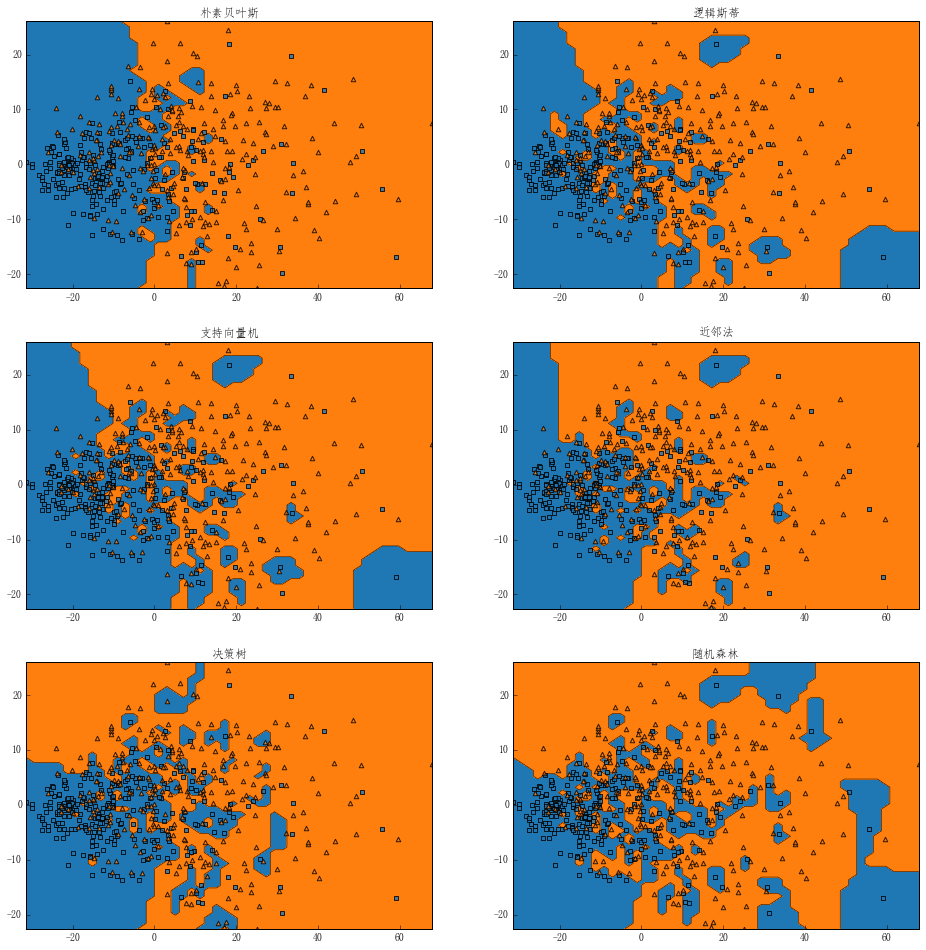

In [111]:
from mlxtend.utils import check_Xy, format_kwarg_dictionaries
# Plotting Decision Regions
gs = gridspec.GridSpec(4, 2)
fig = plt.figure(figsize=(16, 22))

for clf, lab, grd in zip(
    [clf1, clf2, clf3, clf4, clf5, clf6],
    ["朴素贝叶斯", "逻辑斯蒂", "支持向量机", "近邻法", "决策树", "随机森林"],
    itertools.product([0, 1, 2], [0, 1]),
):
    clf.fit(X_train, y_train)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions2(X=X_train.values, y=y_train, clf=clf)
    plt.title(lab)
plt.show()

In [112]:
import itertools

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [113]:
# Initializing Classifiers
ks = [2, 5, 10, 20, 50, 100, 300, 540]
clf_names = ["clf" + str(idx) for idx in range(len(ks))]

KNeighborsClassifier(n_neighbors=2)

Text(0.5, 1.0, 'k=2')

KNeighborsClassifier()

Text(0.5, 1.0, 'k=5')

KNeighborsClassifier(n_neighbors=10)

Text(0.5, 1.0, 'k=10')

KNeighborsClassifier(n_neighbors=20)

Text(0.5, 1.0, 'k=20')

KNeighborsClassifier(n_neighbors=50)

Text(0.5, 1.0, 'k=50')

KNeighborsClassifier(n_neighbors=100)

Text(0.5, 1.0, 'k=100')

KNeighborsClassifier(n_neighbors=300)

Text(0.5, 1.0, 'k=300')

KNeighborsClassifier(n_neighbors=540)

Text(0.5, 1.0, 'k=540')

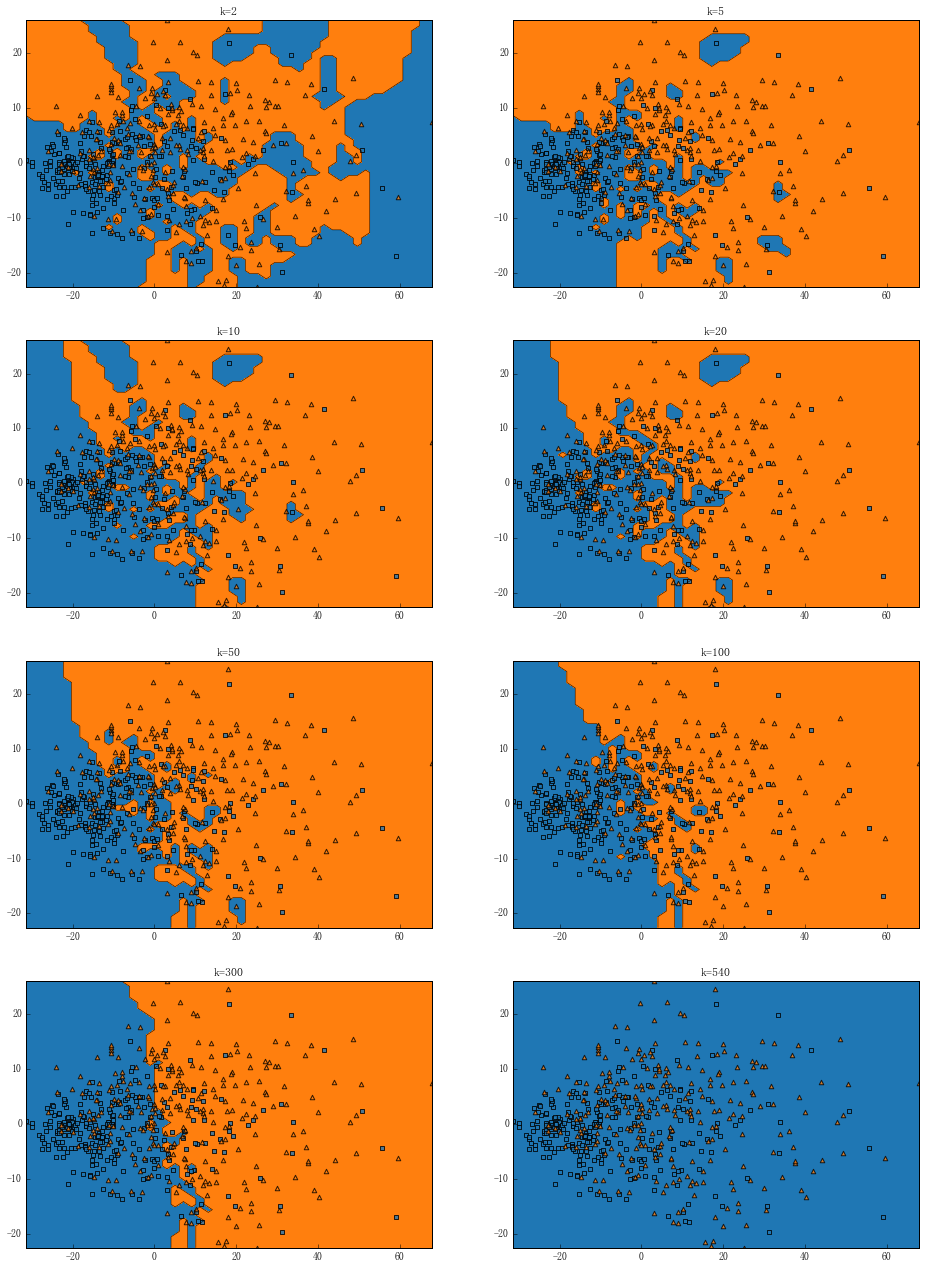

In [114]:
createVar = locals()  # 注意，此处用到了动态生成变量的技巧clf0~clf7，否则就得把语句重复写7遍了
for idx, val in enumerate(ks):
    createVar["clf" + str(idx)] = KNeighborsClassifier(
        n_neighbors=val, p=2, metric="minkowski"
    )
clf_names = ["clf" + str(idx) for idx in range(len(ks))]
# Plotting Decision Regions
gs = gridspec.GridSpec(4, 2)
fig = plt.figure(figsize=(16, 22))

for clf, lab, grd in zip(
    [eval(clf_name) for clf_name in clf_names],
    ["k=" + str(k) for k in ks],
    itertools.product([0, 1, 2, 3], [0, 1]),
):
    clf.fit(X_train, y_train)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions2(X=X_train.values, y=y_train, clf=clf)
    plt.title(lab)
plt.show()

# 讨论

若将本实验的问题情境转换成关联关系的发现，是否可行？有何异同？

<!--NAVIGATION-->
< [学生文理分科A](ch05_学生文理分科A.ipynb) | [Contents](Index.ipynb) | [藻类数量预测](ch06_藻类数量预测.ipynb) >